# Módulo 1 - Unidad 3: Skin Segmentation

El conjunto de datos de Segmentación de Piel está construido sobre el espacio de color B, G, R. El conjunto de datos de Piel y No Piel se genera utilizando texturas de piel de imágenes faciales de personas de diversas edades, géneros y razas.

El conjunto de datos de piel se recopila mediante el muestreo aleatorio de valores B, G, R de imágenes faciales de varios grupos de edad (jóvenes, adultos y ancianos), grupos étnicos (blancos, negros y asiáticos) y géneros obtenidos de la base de datos FERET y la base de datos PAL. El tamaño total de la muestra de aprendizaje es de 245057; de los cuales 50859 son muestras de piel y 194198 son muestras de no piel.

Este conjunto de datos tiene una dimensión de 245057 * 4, donde las primeras tres columnas son valores de B, G, R (características x1, x2 y x3) y la cuarta columna es de las etiquetas de clase (variable de decisión y).

https://archive.ics.uci.edu/dataset/229/skin+segmentation

## Parte 1: Carga de librerías

Se procede a importar las bibliotecas que serán utilizadas a lo largo del desarrollo de este proyecto.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Parte 2: Entendimiento de los datos

Se procede con la carga de los datos con la ayuda de la libreria pandas.

In [2]:
df = pd.read_csv("dataset/Skin_NonSkin.txt", sep="\t", header=None)
df.columns = ["B", "G", "R", "y"]
df.head()

,B,G,R,y
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


Identificar número de muestras y atributos

In [3]:
forma = df.shape
print("Cantidad de registros: {}".format(forma[0]))
print("Cantidad de columnas: {}".format(forma[1]))

Cantidad de registros: 245057
Cantidad de columnas: 4


Identificar el tipo de cada atributo

In [4]:
df.dtypes

B    int64
G    int64
R    int64
y    int64
dtype: object

**Nota:** Se puede apreciar que todas las columnas son de tipo numérico (**int64**)

Resumen medidas estadísticas básicas

In [5]:
df.describe()

,B,G,R,y
count,245057.000000,245057.000000,245057.000000,245057.000000
mean,125.065446,132.507327,123.177151,1.792461
std,62.255653,59.941197,72.562165,0.405546
min,0.000000,0.000000,0.000000,1.000000
25%,68.000000,87.000000,70.000000,2.000000
50%,139.000000,153.000000,128.000000,2.000000
75%,176.000000,177.000000,164.000000,2.000000
max,255.000000,255.000000,255.000000,2.000000


Diagrama de caja y bigotes para todos los atributos

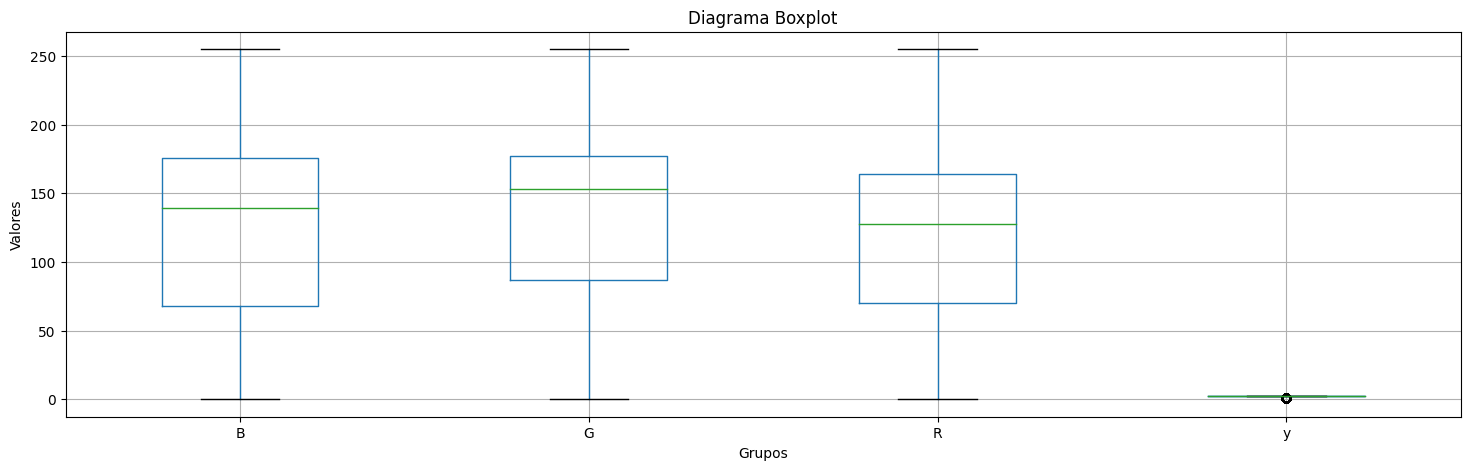

In [6]:
plt.figure(figsize=(18,5))
df.boxplot()
plt.title("Diagrama Boxplot")
plt.xlabel("Grupos")
plt.ylabel("Valores")
plt.show()

**Nota:** El diagrama de caja (boxplot) revela que **no hay** valores atípicos presentes en el conjunto de datos.

Verificación de la distribución de los datos

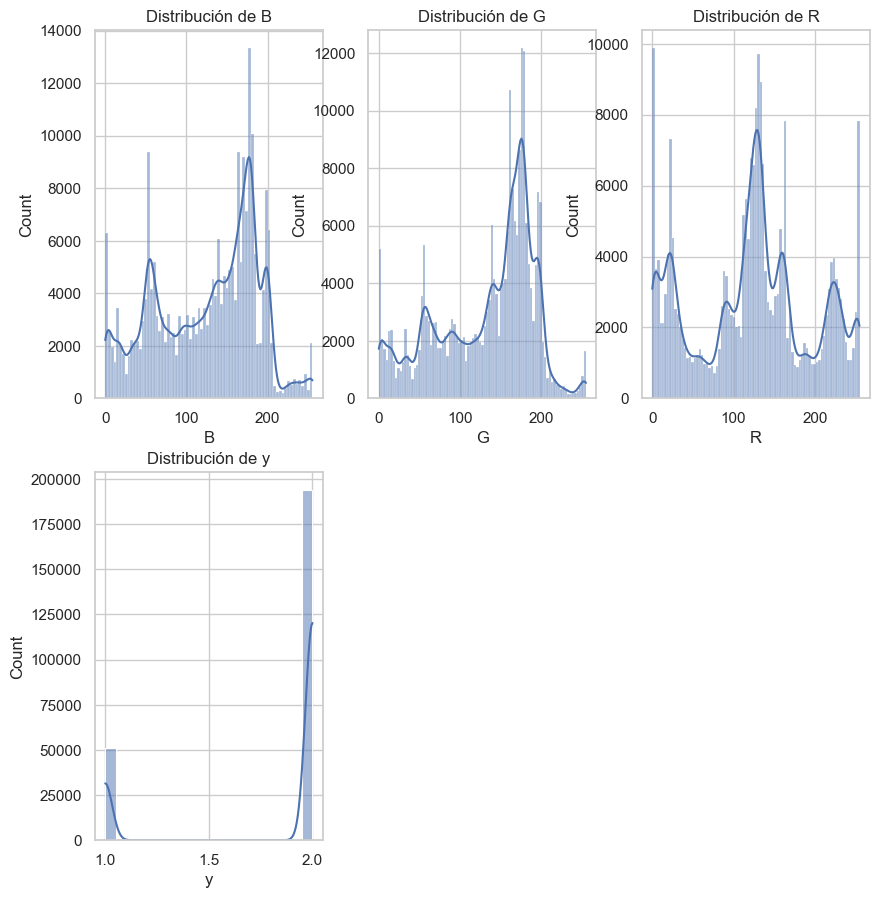

In [7]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,22))

for i, columna in enumerate(df.columns):
    plt.subplot(4,3,i+1)
    sns.histplot(df[columna], kde=True)
    plt.title("Distribución de {}".format(columna))

Calcular la matriz de correlación entre los atributos numéricos

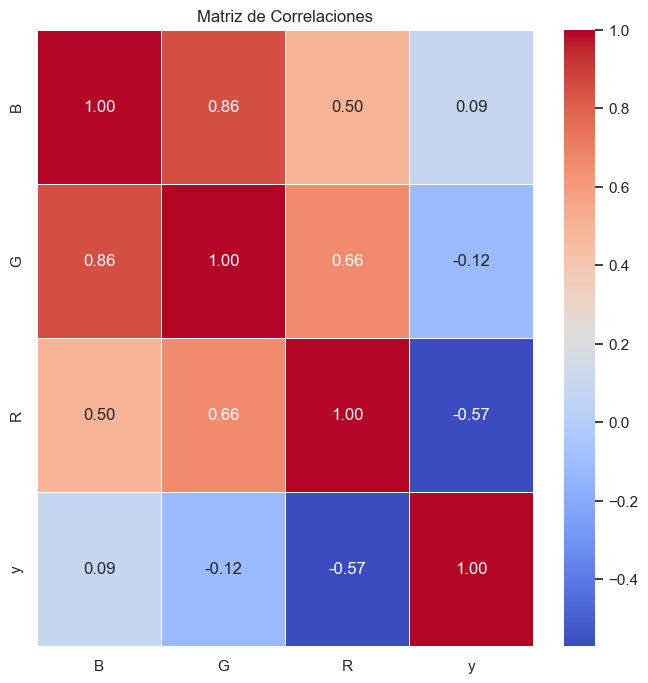

In [8]:
correlaciones = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(correlaciones, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlaciones')
plt.show()

**Nota:** Si consideramos una correlación alta como aquella que excede 0.85, podemos concluir que hay una fuerte correlación entre la variable "G" y la variable "B", con un coeficiente de correlación de 0.86.

f:\Mestria\semestre_2\aprendizaje_automatico\modulo1\unidad3\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


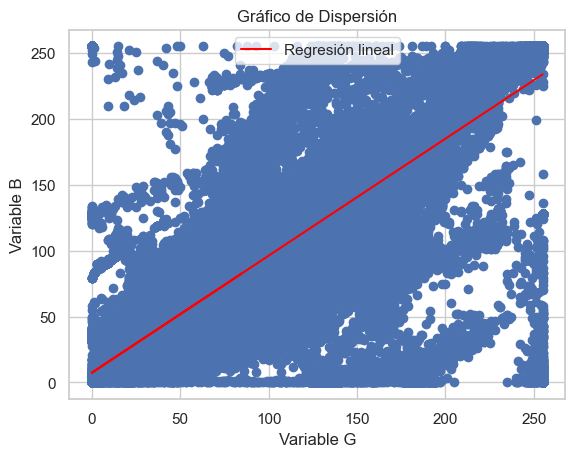

In [9]:
slope, intercept = np.polyfit(df["G"], df["B"], 1)
line = slope * df["G"] + intercept

plt.scatter(
    x=df["G"],
    y=df['B'],    
)
plt.plot(df["G"], line, color='red', linestyle='-', label='Regresión lineal')
plt.title("Gráfico de Dispersión")
plt.xlabel("Variable G")
plt.ylabel("Variable B")
plt.legend()
plt.show()

**Nota:** La gráfica anterior ilustra claramente la relación lineal entre la variable "G" y la variable "B".

Determinar el grado de balanceo entre los valores del atributo objetivo

In [10]:
print(df['y'].value_counts())

2    194198
1     50859
Name: y, dtype: int64


**Nota:** Según la descripción del conjunto de datos, de las 245057 muestras, 50859 corresponden a muestras de piel y 194198 a muestras de no piel. Al analizar el resultado del código anterior, podemos inferir que la clase 2 representa muestras de no piel y la clase 1 representa muestras de piel.

Identificar registros faltantes

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245057 entries, 0 to 245056
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   B       245057 non-null  int64
 1   G       245057 non-null  int64
 2   R       245057 non-null  int64
 3   y       245057 non-null  int64
dtypes: int64(4)
memory usage: 7.5 MB


**Nota:** El análisis del resultado de la función info() revela que todos los atributos cuentan con 245057 valores non-null, lo que concuerda con el número total de registros en el conjunto de datos. Este hallazgo indica que no hay valores nulos presentes en ninguna de las variables, garantizando la integridad de los datos en cada atributo.

Verificar si hay registros repeditos

In [12]:
#Verificando si hay registros duplicados
duplicados = df.duplicated()
total_duplicados = duplicados.sum()
print('Cantidad registros duplicados: {}\n'.format(total_duplicados))

Cantidad registros duplicados: 193613



## Parte 3: Preparación de los datos

Dado que los registros duplicados pueden sesgar el modelo y tener un impacto negativo en su rendimiento, se tomará la decisión de eliminarlos del conjunto de datos.

In [13]:
#Eliminando los registros duplicados
df.drop_duplicates(inplace=True)
df.reset_index()

#Verificando de nuevo si hay registros duplicados
duplicados = df.duplicated()
total_duplicados = duplicados.sum()
print("Cantidad registros duplicados: {}".format(total_duplicados))

Cantidad registros duplicados: 0


Dado que la eliminación de una gran cantidad de registros puede alterar la estructura del conjunto de datos, es necesario volver a generar la matriz de correlación para verificar si aún persiste la correlación entre las variables "G" y "B".

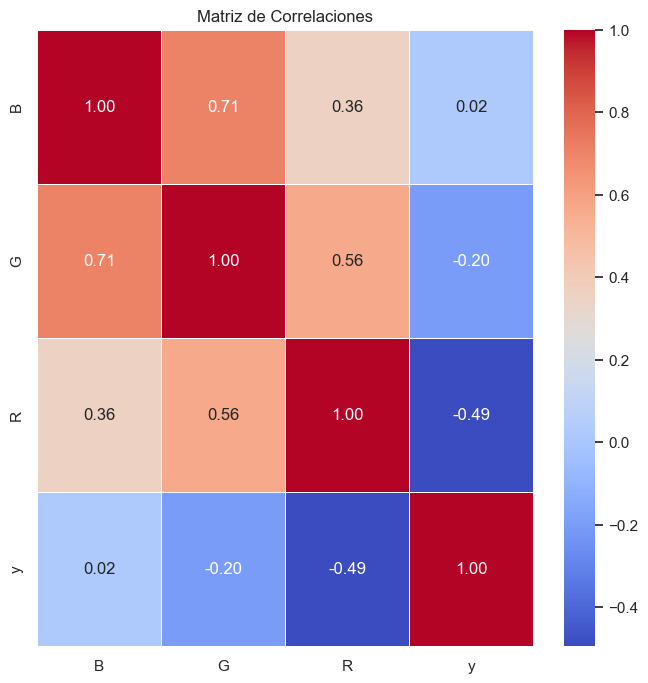

In [14]:
correlaciones = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(correlaciones, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlaciones')
plt.show()

**Nota:** Tras la eliminación de registros duplicados, se observa que ya no se aprecian correlaciones significativas entre los datos, considerando una correlación alta como aquella que supera el umbral de 0.85.

Se procede a revisar nuevamente el equilibrio entre las clases para evaluar cómo ha sido afectado después de la eliminación de registros duplicados.

In [15]:
print(df['y'].value_counts())

2    36790
1    14654
Name: y, dtype: int64


Dado el desequilibrio entre las clases, se ha optado por aplicar el método de submuestreo para equilibrarlas.

In [16]:
conteo_clases = df['y'].value_counts()
clase_menor = conteo_clases.idxmin()
num_instancias_menor = conteo_clases.min()
df = pd.concat([
    df[df['y'] == clase_menor],
    df[df['y'] != clase_menor].sample(n=num_instancias_menor, random_state=42)
])
# Verificar la distribución de clases después del submuestreo
print(df['y'].value_counts())


1    14654
2    14654
Name: y, dtype: int64


**Nota:** Después de completar el proceso de submuestreo, se observa que ambas clases ahora tienen una cantidad de muestras equilibrada, lo que indica que el conjunto de datos está balanceado.

## Parte 4: Modelo

Se crea un modelo de regresión logística para la clasificación binaria 

In [17]:
modelo = LogisticRegression()

## Parte 5: N-folds validation

Se emplea la validación cruzada con diez pliegues (N-folds, n = 10).

In [31]:
X = df.drop(labels=['y'], axis=1)
y = df['y']

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Listas para almacenar las métricas
accuracy_list = []
sensitivity_list = []
specificity_list = []
precision_list = []
f1_score_list = []

for train_index, test_index in kf.split(X=X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Entrenar el modelo
    modelo.fit(X_train, y_train)

    #Realizar predicciones en el conjunto de prueba
    y_pred = modelo.predict(X=X_test)

    #calcular el accuracy
    accuracy_list.append(accuracy_score(y_true=y_test, y_pred=y_pred))

    #Calcular la matriz de confusión
    conf_matriz = confusion_matrix(y_true=y_test, y_pred=y_pred)

    #Calcular especificidad
    tn, fp, fn, tp = conf_matriz.ravel()
    specificity = tn / (tn + fp)
    specificity_list.append(specificity)

    #Calcular la sensibilidad (recall)
    sensitivity_list.append(recall_score(y_true=y_test, y_pred=y_pred))

    #Calcular la precisión
    precision_list.append(precision_score(y_true=y_test, y_pred=y_pred))

    #Calcular F1-score
    f1_score_list.append(f1_score(y_true=y_test, y_pred=y_pred))

#Imprimir los resultados
print("Resultados de N-folds validation:\n")
print("Promedio de Accuracy:\t\t{:.2%}".format(sum(accuracy_list) / len(accuracy_list)))
print("Promedio de Sensitivity:\t{:.2%}".format(sum(sensitivity_list) / len(sensitivity_list)))
print("Promedio de Specificity:\t{:.2%}".format(sum(specificity_list) / len(specificity_list)))
print("Promedio de Precision:\t\t{:.2%}".format(sum(precision_list) / len(precision_list)))
print("Promedio de F1-score:\t\t{:.2%}".format(sum(f1_score_list) / len(f1_score_list)))




Resultados de N-folds validation:

Promedio de Accuracy:		84.89%
Promedio de Sensitivity:	89.97%
Promedio de Specificity:	89.97%
Promedio de Precision:		81.69%
Promedio de F1-score:		85.62%


## Parte 6: random subsampling

Se utiliza la validación mediante muestreo aleatorio.

In [37]:
for i in range(10):
    # Dividir datos de manera aleatoria en 70/30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
    #Entrenar el modelo
    modelo.fit(X=X_train, y=y_train)
    y_pred = modelo.predict(X=X_test)

    # Calcular y almacenar las métricas
    accuracy_list.append(accuracy_score(y_test, y_pred))
    
    # Calcular matriz de confusión
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Calcular sensibilidad (recall)
    sensitivity_list.append(recall_score(y_test, y_pred))
    
    # Calcular especificidad
    specificity = tn / (tn + fp)
    specificity_list.append(specificity)
    
    # Calcular precisión
    precision_list.append(precision_score(y_test, y_pred))
    
    # Calcular F1-score
    f1_score_list.append(f1_score(y_test, y_pred))

# Imprimir métricas promedio
print("Promedio de métricas:\n")
print("Promedio de Accuracy:\t\t{:.2%}".format(sum(accuracy_list) / len(accuracy_list)))
print("Promedio de Sensitivity:\t{:.2%}".format(sum(sensitivity_list) / len(sensitivity_list)))
print("Promedio de Specificity:\t{:.2%}".format(sum(specificity_list) / len(specificity_list)))
print("Promedio de Precision:\t\t{:.2%}".format(sum(precision_list) / len(precision_list)))
print("Promedio de F1-score:\t\t{:.2%}".format(sum(f1_score_list) / len(f1_score_list)))

Promedio de métricas:

Promedio de Accuracy:		84.92%
Promedio de Sensitivity:	89.88%
Promedio de Specificity:	89.88%
Promedio de Precision:		81.81%
Promedio de F1-score:		85.65%


## Parte 7: Análisis de resultados

Después de realizar la validación cruzada con diez pliegues y la validación mediante muestreo aleatorio para el modelo de regresión logística, se observa que ambos métodos producen resultados bastante similares en términos de métricas de evaluación.

El promedio de Accuracy, Sensitivity (o Recall), Specificity, Precision y F1-score es consistentemente alto en ambos casos, lo que indica que el modelo de regresión logística tiene un buen rendimiento general en la clasificación de los datos.

El hecho de que los resultados de ambas validaciones sean comparables sugiere que el modelo es robusto y que los resultados no dependen significativamente del esquema de validación utilizado. Esto es una buena señal, ya que indica que el modelo es generalizable y no está sobreajustado a un conjunto de datos particular.